<a href="https://colab.research.google.com/github/bieri2/ATMS-597-Project-4-Wx-Prediction/blob/master/GroupE_Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import necessary modules
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## KCMI Observations

In [0]:
# Read in daily KCMI data 
kcmi_daily = pd.read_csv('/content/drive/My Drive/project4_data/KCMI_daily.csv', 
                         header = 4, dtype = {'Max Hourly Temp (F)': np.float64, 
                                              'Min Hourly Temp (F)': np.float64, 
                                              'Max Wind Speed (mph)': np.float64, 
                                              'Total Precip (in)': np.float64}, 
                         na_values = 'M')[:-7]
# Drop unnecessary column
kcmi_daily = kcmi_daily.drop(columns = 'Unnamed: 5')
# Set 'Date' column as index
kcmi_daily = kcmi_daily.set_index(pd.to_datetime(kcmi_daily['Date'])).drop(columns = 'Date')
# Resample to fill in missing days with NaNs
kcmi_daily = kcmi_daily.resample('D').mean()

In [0]:
# Read in hourly KCMI data
kcmi_hourly = pd.read_csv('/content/drive/My Drive/project4_data/KCMI_hourly.csv', na_values = 'M')
# Set 'Timestep' column as index
kcmi_hourly = kcmi_hourly.set_index(pd.to_datetime(kcmi_hourly['Timestamp'])).drop(columns = 'Timestamp')
kcmi_hourly = kcmi_hourly['2010-01-01':'2019-12-31']
kcmi_hourly['pr1h'][kcmi_hourly['pr1h'] < 0] = np.NaN

In [0]:
# Resample hourly data to daily by summing hourly values
kcmi_hourly_resampled = kcmi_hourly.resample('D').apply(lambda x: x.values.sum())

In [0]:
# Get boolean array which indicates locations of missing data 
missing = kcmi_daily['Total Precip (in)'].isnull()

In [0]:
# Replace missing daily precip data with aggregated hourly data
kcmi_daily['Total Precip (in)'][missing] = kcmi_hourly_resampled['pr1h'][missing].astype('float')

In [0]:
kcmi_daily['Max Hourly Temp (F)'] = (kcmi_daily['Max Hourly Temp (F)'] - 32.)/1.8
kcmi_daily['Min Hourly Temp (F)'] = (kcmi_daily['Min Hourly Temp (F)'] - 32.)/1.8
#kcmi_daily['Max Wind Speed (mph)'] = kcmi_daily['Max Wind Speed (mph)']/2.237
#kcmi_daily['Total Precip (in)'] = kcmi_daily['Total Precip (in)']*25.4

In [0]:
# Get data for 2019 for validation
kcmi_2019  = kcmi_daily['2019-01-01':'2019-12-31']
# Get data only from 2010 to 2018
kcmi_train = kcmi_daily['2010-01-01':'2018-12-31']

## GFS Data

In [0]:
# Code to decompress tar.gz files and add to directory
# Only need to do this once, should be saved to Drive

# ! mkdir '/content/drive/My Drive/project4_data/sfc_tar'
# ! gunzip '/content/drive/My Drive/project4_data/sfc.tar.gz' 
# ! tar -xvf '/content/drive/My Drive/project4_data/sfc.tar' --directory '/content/drive/My Drive/project4_data/sfc_tar'

In [0]:
# Paths to files for different GFS datasets
gfs_daily_dir = '/content/drive/My Drive/project4_data/daily_tar/bufkit/'
gfs_prof_dir  = '/content/drive/My Drive/project4_data/prof_tar/bufkit/'
gfs_sfc_dir   = '/content/drive/My Drive/project4_data/sfc_tar/bufkit/'

In [0]:
# Define function to read in GFS daily data one day at a time
# Once all files have been read, combine into one DataFrame
def get_gfs_data(gfs_dir):

  # Get list of files to be read
  files = os.listdir(gfs_dir)
  # Sort so that files are in order by date
  files.sort()
  # Create list of full paths for all files
  file_list = [gfs_dir + f for f in files]

  # Create empty list to hold data
  all_dfs = []

  # Read in each file and add data to list
  for f in file_list: 
    print(f)
    current = pd.read_csv(f)
    all_dfs.append(current)

  # Create one DataFrame will all data 
  all_dfs = pd.concat(all_dfs)

  return all_dfs

In [12]:
# Read in daily GFS data
gfs_daily = get_gfs_data(gfs_daily_dir)

/content/drive/My Drive/project4_data/daily_tar/bufkit/2010010112.gfs_kcmi.buf_daily.csv
/content/drive/My Drive/project4_data/daily_tar/bufkit/2010010212.gfs_kcmi.buf_daily.csv
/content/drive/My Drive/project4_data/daily_tar/bufkit/2010010312.gfs_kcmi.buf_daily.csv
/content/drive/My Drive/project4_data/daily_tar/bufkit/2010010412.gfs_kcmi.buf_daily.csv
/content/drive/My Drive/project4_data/daily_tar/bufkit/2010010512.gfs_kcmi.buf_daily.csv
/content/drive/My Drive/project4_data/daily_tar/bufkit/2010010612.gfs_kcmi.buf_daily.csv
/content/drive/My Drive/project4_data/daily_tar/bufkit/2010010712.gfs_kcmi.buf_daily.csv
/content/drive/My Drive/project4_data/daily_tar/bufkit/2010010812.gfs_kcmi.buf_daily.csv
/content/drive/My Drive/project4_data/daily_tar/bufkit/2010010912.gfs_kcmi.buf_daily.csv
/content/drive/My Drive/project4_data/daily_tar/bufkit/2010011012.gfs_kcmi.buf_daily.csv
/content/drive/My Drive/project4_data/daily_tar/bufkit/2010011112.gfs_kcmi.buf_daily.csv
/content/drive/My Dri

In [0]:
# Name unnamed column
gfs_daily = gfs_daily.rename(columns={'Unnamed: 0': 'Timestamp'})

In [0]:
# Set timestamp as index
gfs_daily = gfs_daily.set_index(pd.to_datetime(gfs_daily['Timestamp'])).drop(columns = 'Timestamp')
# Resample to fill any missing days
gfs_daily = gfs_daily.resample('D').mean()

In [0]:
# Separate into training and validation datasets
gfs_2019  = gfs_daily['2019-01-01':'2019-12-31']
gfs_train = gfs_daily['2010-01-01':'2018-12-31']

## Prediction via regression

In [0]:
# Increase all dates in index by one day since GFS forecasts apply to the following day
gfs_train = gfs_train.set_index(gfs_train.index + pd.Timedelta(days=1))

In [0]:
# Create one dataframe with observations and GFS data for training
all_train_data  = pd.concat([kcmi_train['2010-01-02':], gfs_train[:'2018-12-31']], axis=1)

In [0]:
# Fill in missing values (NaNs) using bfill and ffill
# Doing this because regression function does not handle NaNs
all_train_data = all_train_data.bfill().ffill()
gfs_2019 = gfs_2019.bfill().ffill()

In [0]:
# Define function to apply regression
def reg_predict(x, y, predict):

  model = LinearRegression(fit_intercept=True, normalize=True)  
  model.fit(x, y)
  train, predict = model.predict(x), model.predict(predict)
  return train, predict

In [0]:
# Get predicted values from training data (_train) and predicted values for 2019 (_predict) 
Tmax_train, Tmax_predict = reg_predict(all_train_data[['TMAX']], all_train_data['Max Hourly Temp (F)'], gfs_2019[['TMAX']])
Tmin_train, Tmin_predict = reg_predict(all_train_data[['TMIN']], all_train_data['Min Hourly Temp (F)'], gfs_2019[['TMIN']])
Wmax_train, Wmax_predict = reg_predict(all_train_data[['WMAX']], all_train_data['Max Wind Speed (mph)'], gfs_2019[['WMAX']])
Precip_train, Precip_predict = reg_predict(all_train_data[['RTOT']], all_train_data['Total Precip (in)'], gfs_2019[['RTOT']])

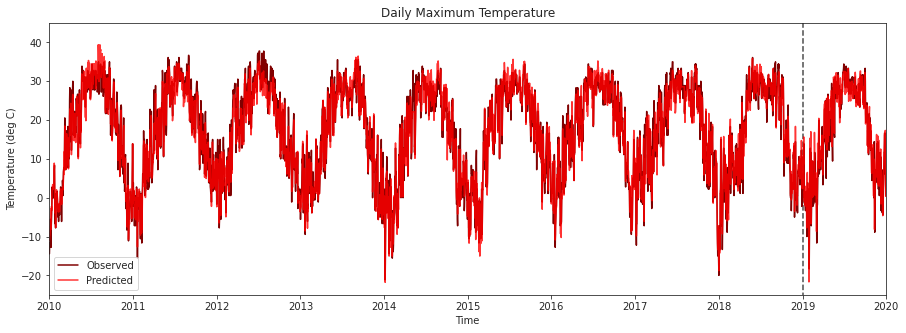

In [23]:
%matplotlib inline
sns.set_style('ticks')

# Plot predicted vs. actual Tmax
# Dashed vertical line denotes beginning of 2019
time = np.concatenate((all_train_data.index.values, gfs_2019.index.values))
plt.figure(figsize=(15,5))
plt.plot(time, np.concatenate((all_train_data['Max Hourly Temp (F)'].values, kcmi_2019['Max Hourly Temp (F)'].values)), 
                        color = 'maroon', label = 'Observed')
plt.plot(time, np.concatenate((Tmax_train, Tmax_predict)), color = 'red', alpha = 0.8, label = 'Predicted')
plt.vlines(dt.datetime(2019, 1, 1), -30, 45, linestyles = 'dashed', alpha = 0.7)
plt.legend(loc = 'lower left')
plt.title('Daily Maximum Temperature')
plt.ylabel('Temperature (deg C)')
plt.xlabel('Time')
plt.xlim(time[0]-pd.Timedelta(days=1),  time[-1]+pd.Timedelta(days=1))
plt.ylim(-25, 45)
plt.show()

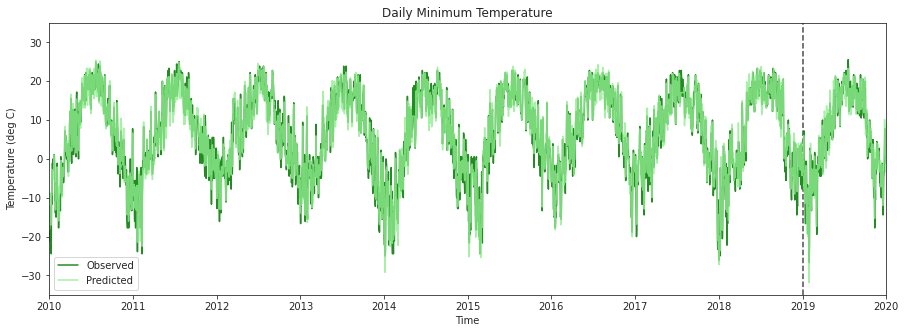

In [24]:
# Plot predicted vs. actual Tmin

plt.figure(figsize=(15,5))
plt.plot(time, np.concatenate((all_train_data['Min Hourly Temp (F)'].values, kcmi_2019['Min Hourly Temp (F)'].values)), 
                        color = 'forestgreen', label = 'Observed')
plt.plot(time, np.concatenate((Tmin_train, Tmin_predict)), color = 'lightgreen', alpha = 0.8, label = 'Predicted')
plt.vlines(dt.datetime(2019, 1, 1), -35, 35, linestyles = 'dashed', alpha = 0.7)
plt.legend(loc='lower left')
plt.title('Daily Minimum Temperature')
plt.ylabel('Temperature (deg C)')
plt.xlabel('Time')
plt.xlim(time[0]-pd.Timedelta(days=1),  time[-1]+pd.Timedelta(days=1))
plt.ylim(-35, 35)
plt.show()

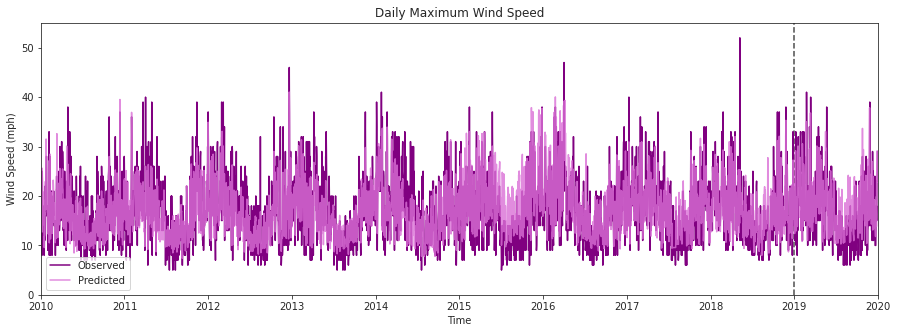

In [25]:
# Plot predicted vs. actual Wmax

plt.figure(figsize=(15,5))
plt.plot(time, np.concatenate((all_train_data['Max Wind Speed (mph)'].values, kcmi_2019['Max Wind Speed (mph)'].values)), 
                        color = 'purple', label = 'Observed')
plt.plot(time, np.concatenate((Wmax_train, Wmax_predict)), color = 'orchid', alpha = 0.8, label = 'Predicted')
plt.vlines(dt.datetime(2019, 1, 1), 0, 55, linestyles = 'dashed', alpha = 0.7)
plt.legend(loc='lower left')
plt.title('Daily Maximum Wind Speed')
plt.ylabel('Wind Speed (mph)')
plt.xlabel('Time')
plt.xlim(time[0]-pd.Timedelta(days=1),  time[-1]+pd.Timedelta(days=1))
plt.ylim(0, 55)
plt.show()

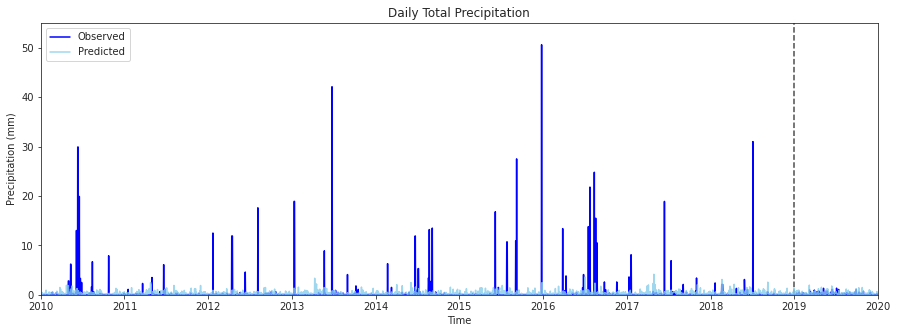

In [26]:
# Plot predicted vs. actual Precip

plt.figure(figsize=(15,5))
plt.plot(time, np.concatenate((all_train_data['Total Precip (in)'].values, kcmi_2019['Total Precip (in)'].values)), 
                        color = 'blue', label = 'Observed')
plt.plot(time, np.concatenate((Precip_train, Precip_predict)), color = 'skyblue', alpha = 0.8, label = 'Predicted')
plt.vlines(dt.datetime(2019, 1, 1), 0, 55, linestyles = 'dashed', alpha = 0.7)
plt.legend(loc='upper left')
plt.title('Daily Total Precipitation')
plt.ylabel('Precipitation (mm)')
plt.xlabel('Time')
plt.xlim(time[0]-pd.Timedelta(days=1),  time[-1]+pd.Timedelta(days=1))
plt.ylim(0, 55)
plt.show()